<h1> Dogs v Cats </h1>

Attempting the dogs vs cats classifier from kaggle. Will be attempting this with different models

[Source: kaggle dogs vs cats](https://www.kaggle.com/c/dogs-vs-cats)

<a id='TOC'></a>
<h2>Table of Contents</h2>
<div class="alert alert-block alert-info" style="margin-top: 20px">
    <ul>
        <li>
            <a href="#download">Download Dataset from Kaggle</a>
        </li>
        <li>
            <a href="#preprocess">Preprocessing Images</a>
        </li>
        <li>
            <a href="#dataframe">Cleaning Dataframe</a>
        </li>
        <li>
            <a href="#logreg">Logistic Regression using Scikit-Learn</a>
        </li>
        <li>
            <a href="#conclusion">Conclusion</a>
        </li>
    </ul>

In [99]:
import os, zipfile
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

#import kaggle
from kaggle.api.kaggle_api_extended import KaggleApi

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

<a id='download'></a>
<h2>Download Dataset from Kaggle</h2>

In [2]:
api = KaggleApi()
api.authenticate()

In [12]:
source = 'dogs-vs-cats'
train_filename = 'train.zip'
test_filename = 'test1.zip'
filepath = './'

api.competition_download_file(source, train_filename, path=filepath)
api.competition_download_file(source, test_filename, path=filepath)

train.zip: Skipping, found more recently modified local copy (use --force to force download)
test1.zip: Skipping, found more recently modified local copy (use --force to force download)


In [14]:
with zipfile.ZipFile(train_filename, 'r') as z:
    z.extractall()

with zipfile.ZipFile(test_filename, 'r') as z:
    z.extractall()

Processing files into dataframe

In [3]:
filenames = os.listdir('./train')
print('number of images: {}'.format(len(filenames)))

number of images: 25000


In [4]:
# dictionary where key is filename and value is label
image_dict = {}
for fn in filenames:
    label = fn.split('.')[0]
    image_dict[fn] = label

In [5]:
df = pd.DataFrame.from_dict(image_dict, orient='index', columns=['label'])
df.reset_index(inplace=True)
df.rename(columns={'index':'filename'}, inplace=True)

In [6]:
df.head()

,filename,label
0,cat.0.jpg,cat
1,cat.1.jpg,cat
2,cat.10.jpg,cat
3,cat.100.jpg,cat
4,cat.1000.jpg,cat


In [7]:
df.tail()

,filename,label
24995,dog.9995.jpg,dog
24996,dog.9996.jpg,dog
24997,dog.9997.jpg,dog
24998,dog.9998.jpg,dog
24999,dog.9999.jpg,dog


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  25000 non-null  object
 1   label     25000 non-null  object
dtypes: object(2)
memory usage: 390.8+ KB


In [9]:
df.describe()

,filename,label
count,25000,25000
unique,25000,2
top,cat.2844.jpg,dog
freq,1,12500


In [10]:
df['label'].value_counts()

dog    12500
cat    12500
Name: label, dtype: int64

Displaying a 10 sample images for checking purposes

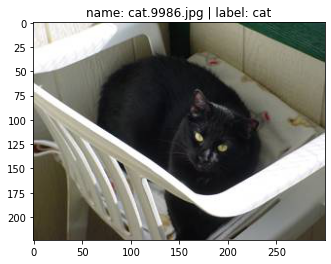

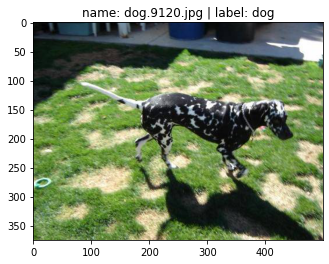

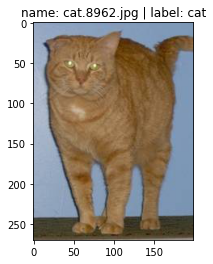

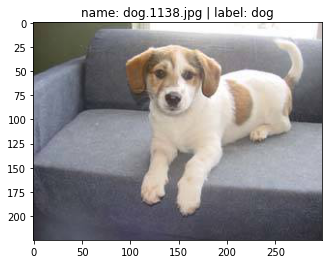

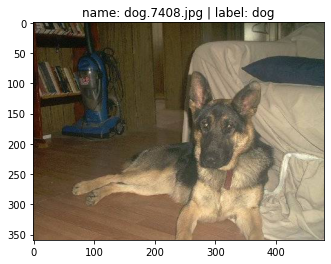

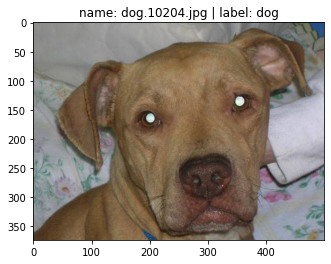

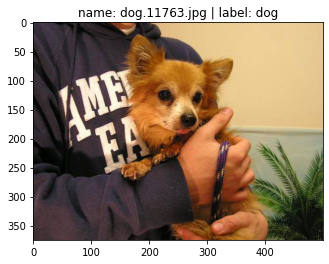

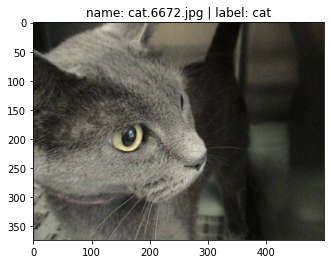

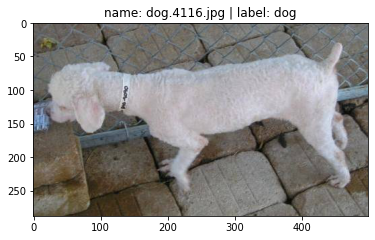

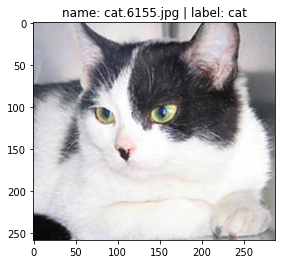

In [11]:
sample_images = df.sample(10)

for fn, l in sample_images.to_numpy():
    img = mpimg.imread('./train/' + fn)
    plt.imshow(img)
    plt.title('name: {} | label: {}'.format(fn, l))
    plt.show()

<b><a href='#TOC'>Back to top</a></b>

<a id='preprocess'></a>
<h2>Preprocessing images</h2>
<ul>Resize the image to 32 x 32 and make grayscale. Store processed images in <b>train_process</b> folder</ul>

In [13]:
from PIL import Image, ImageOps

In [59]:
processed_path = './train_processed/'
if not os.path.exists(processed_path):
    os.makedirs(processed_path)

In [60]:
for fn in tqdm(df.filename):
    img = Image.open('./train/' + fn)
    img = ImageOps.grayscale(img.resize((32, 32)))
    img.save(processed_path + fn)

100%|████████████████████████████████████| 25000/25000 [05:28<00:00, 76.18it/s]


<b><a href='#TOC'>Back to top</a></b>

<a id='dataframe'></a>
<h2>Cleaning Dataframe</h2>

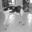

In [61]:
img = Image.open(processed_path + df.filename.sample().tolist()[0])
img

In [62]:
np.array(img).reshape(1, -1)[0]

array([157, 134,  77, ..., 177, 176, 178], dtype=uint8)

In [63]:
raw_img_list = []
#count = 0
for fn in tqdm(df.filename):
    img = Image.open(processed_path + fn)
    raw_img_list.append(np.array(img).reshape(1, -1)[0])
    #count += 1
    #if count == 10:
    #    break

100%|███████████████████████████████████| 25000/25000 [03:41<00:00, 112.79it/s]


In [65]:
df['raw'] = raw_img_list

In [66]:
df.head()

,filename,label,raw
0,cat.0.jpg,cat,"[172, 189, 199, 199, 206, 215, 207, 189, 164, ..."
1,cat.1.jpg,cat,"[43, 41, 53, 49, 38, 45, 53, 61, 67, 69, 88, 1..."
2,cat.10.jpg,cat,"[48, 55, 65, 57, 65, 69, 47, 47, 46, 52, 55, 4..."
3,cat.100.jpg,cat,"[228, 229, 228, 227, 229, 233, 233, 229, 225, ..."
4,cat.1000.jpg,cat,"[100, 100, 117, 161, 219, 204, 244, 210, 191, ..."


Back up data for future use

In [68]:
df.to_csv('dogsvcats_32x32.csv', index=False)

Taking a subset of dataframe as the number of data is too large

In [71]:
df_cat = df[df.label=='cat']
df_dog = df[df.label=='dog']

In [189]:
df_sub = pd.concat([df_cat.sample(100), df_dog.sample(100)])
df_sub

,filename,label,raw
7324,cat.534.jpg,cat,"[98, 68, 18, 58, 69, 58, 111, 106, 35, 0, 5, 1..."
1238,cat.11110.jpg,cat,"[157, 168, 178, 188, 183, 100, 72, 73, 114, 19..."
4781,cat.3050.jpg,cat,"[172, 180, 194, 205, 202, 189, 180, 179, 195, ..."
5357,cat.357.jpg,cat,"[40, 59, 85, 103, 108, 102, 93, 88, 123, 136, ..."
9363,cat.7175.jpg,cat,"[105, 76, 90, 86, 96, 101, 77, 111, 22, 124, 1..."
...,...,...,...
24704,dog.9732.jpg,dog,"[112, 100, 111, 86, 83, 92, 94, 160, 145, 179,..."
20111,dog.5599.jpg,dog,"[137, 154, 155, 138, 137, 152, 153, 138, 141, ..."
20327,dog.5793.jpg,dog,"[252, 254, 255, 246, 255, 145, 95, 86, 99, 132..."
23818,dog.8935.jpg,dog,"[48, 30, 9, 73, 119, 22, 9, 28, 51, 70, 60, 58..."


<b><a href='#TOC'>Back to top</a></b>

<a id='logreg'></a>
<h2>Logistic Regression using Scikit-Learn</h2>

In [190]:
X = pd.DataFrame(df_sub.raw.to_list())

In [191]:
y = df_sub.label

In [192]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=2)

In [193]:
%%time
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

Wall time: 176 ms


LogisticRegression(max_iter=1000)

In [194]:
lr.score(X_test, y_test)

0.325

In [177]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report

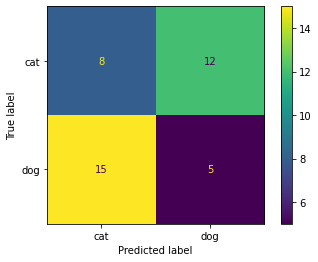

In [195]:
plot_confusion_matrix(lr, X_test, y_test)

In [196]:
yhat = lr.predict(X_test)

In [197]:
print(classification_report(yhat, y_test))

              precision    recall  f1-score   support

         cat       0.40      0.35      0.37        23
         dog       0.25      0.29      0.27        17

    accuracy                           0.33        40
   macro avg       0.33      0.32      0.32        40
weighted avg       0.34      0.33      0.33        40



<b><a href='#TOC'>Back to top</a></b>

<a id='conclusion'></a>
<h2>Conclusion</h2>

The performance is just too terrible. It might be reasonable to use SK-Learn on the MNIST dataset but insufficient to model for the dogs v cats dataset

<b>Some key takeaways</b>
<li>Jupyter notebook is nicely formatted with hyperlinks within the notebook</li>
<li>Got to try using the Kaggle API for the first time.</li>
<li>Got to use pillow library for manupilating images (resize and grayscale)</li>

<b><a href='#TOC'>Back to top</a></b>